## Image processing
### Angel Alvarez. @Anggel7x

In this notebook I perform the clipping, filtering and conversion of more than 51 thousand images of German traffic signs to be used in a deep neural network for classification.

The test set consists of more than 12 thousand RGB images of various sizes. The images are in <code>.ppm</code> format and are numbered in ascending order. They do not have any order and it can be said that they are random.

Annotations are saved in a <code>.csv</code> file separated by a <code>;</code>. In detail, the <code>csv</code> has the following columns:

* <code>Filename</code> The name of the image file to which the information refers
* <code>Width</code>, <code>Heigth</code> Dimensions of the image.
* <code>Roi.x1, Roi.y1, Roi.x2, Roi.y2</code> Location of the signal within the image.
* <code>ClassId</code> An integer between 0 and 42 marking the classification of the traffic sign.

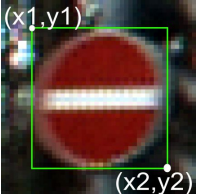


### Description of data

The training set contains one directory for each of the 43 classes (00000 - 00043). Each directory contains the images and a <code>.csv</code> with the annotations equal to the test set.

Images have names in the format <code>GT_ENUM.ppm</code>

The idea is then to process each of these images and create two <code>.npz</code> files (numpy array files) that have an array <code>X</code> for the array of images that is scaled by grays and an array <code>Y</code> with the corresponding classification.

For our task we will rely on three fundamental libraries: <code>Pillow</code> to process images, <code>pandas</code> to read <code>.csv</code> and <code>numpy< /code> to create the arrays.

In [ ]:
import os
import glob
import pandas as pd
from PIL import Image
import numpy as np

### Testing set processing

First I will proceed to clean and extract the information from the test set because it is the simplest

In [ ]:
images_df = pd.read_csv('GTSRB/Final_Test/Images/GT-final_test.csv', sep=';')
images_df

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.ppm,53,54,6,5,48,49,16
1,00001.ppm,42,45,5,5,36,40,1
2,00002.ppm,48,52,6,6,43,47,38
3,00003.ppm,27,29,5,5,22,24,33
4,00004.ppm,60,57,5,5,55,52,11
...,...,...,...,...,...,...,...,...
12625,12625.ppm,42,41,5,6,37,36,12
12626,12626.ppm,50,51,6,5,45,46,33
12627,12627.ppm,29,29,6,6,24,24,6
12628,12628.ppm,48,49,5,6,43,44,7


Now we will analyze each of the images: cropping the space that contains the signal, changing the resolution to 64x64, converting it to a grayscale and then to an array with the data from 0-255.

In [ ]:
directory = 'GTSRB/Final_Test/Images'
test_save_file = 'processed/test_data.npz'
img_arrays = []
labels = []

for filename in os.listdir(directory):

    if filename[-4:] == '.csv' : continue
    # Open the image
    

    # Look up for the real sign pixels content (box)
    try:
        img = Image.open(directory+'/'+filename)
        
        img_values = tuple(images_df[images_df['Filename'] == filename].values.tolist()[0]) # Scrap of the data inside the .csv
        box = img_values[3:7] 
        label = img_values[-1]

        labels.append(label) # Ys

        # Process the image

        img_processed = img.crop(box) # Crop the image to only contain the sign pixels
        img_processed = img_processed.resize((64,64)) # We resize to a standard size of 64x64
        img_processed = img_processed.convert('L') # We put the color down and use grayscale
        
        img_arrays.append(np.asarray(img_processed).reshape(64*64)) # X

    except:
        print(f'{filename} Not found, skipped')


11850.ppm Not found, skipped


We now create the arrays and the <code>.npz</code> file

In [ ]:
X = np.array(img_arrays)
Y = np.array(labels).reshape(-1, 42)

np.savez(test_save_file, X=X, Y=Y)

In [ ]:
test_data = np.load(test_save_file)
X_test, Y_test  = test_data['X'], test_data['Y']
print(X_test.shape, Y_test.shape)

(12629, 4096) (12629, 42)


### Training set processing

In a very similar way we can process the data from the training set.

In [ ]:
directory = 'GTSRB/Final_Training/Images'
training_save_file = 'processed/training_data.npz'
img_arrays = []
labels = []


for folder in os.listdir(directory):
    folder_directory = directory+'/'+folder
    csv_file = glob.glob(os.path.join(folder_directory, "*.csv"))
    df = pd.read_csv(csv_file[0], sep=';')


    for filename in os.listdir(folder_directory):
        
        if filename[-4:] == ".csv": continue

        try:
            # Open the image
            img = Image.open(folder_directory+'/'+filename)
            img_values = tuple(df[df['Filename'] == filename].values.tolist()[0])

            box = img_values[3:7] 
            label = img_values[-1]
            labels.append(label) # Ys

            # Process the image

            img_processed = img.crop(box) # Crop the image to only contain the sign pixels
            img_processed = img_processed.resize((64,64)) # We resize to a standard size of 64x64
            img_processed = img_processed.convert('L') # We put the color down and use grayscale

            img_arrays.append(np.asarray(img_processed).reshape(64*64)) # X    

        except:
            print(f'{filename} Not found, skipped')

In [ ]:
X = np.array(img_arrays)
Y = np.array(labels).reshape(-1, 42)

np.savez(training_save_file, X=X, Y=Y)
print(X.shape, Y.shape)

(39209, 4096) (39209, 42)


In [ ]:
training_data = np.load(training_save_file)
X_train, Y_train  = training_data['X'], training_data['Y']
print(X_train.shape, Y_train.shape)

(39209, 4096) (39209, 42)


At the end of the process we have two files: <code>test_data.npz</code> and <code>train_data.npz</code>